# RadarCOVID-Report

In [1]:
import matplotlib
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

## COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_df.drop(columns=["Country_EN", "Country_ES", "Country_IT", "Region"], inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.head()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-01-23,0.0,NaN,NaN
1,2020-01-24,0.0,0.0,NaN
2,2020-01-25,0.0,0.0,NaN
3,2020-01-26,0.0,0.0,NaN
4,2020-01-27,0.0,0.0,NaN


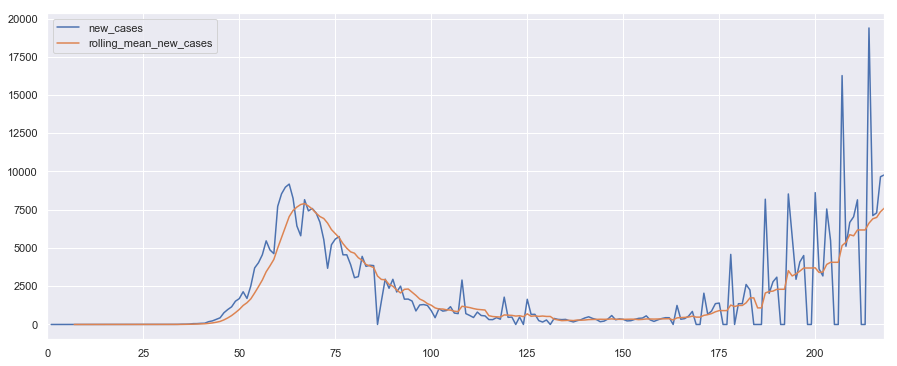

In [4]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

## RadarCOVID TEKs Extraction

In [5]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=30)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

,sample_date_string,source_url,region,key_data
0,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,757936ab-531c-4872-1d83-ce7a8d135211
1,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,51d5fc97-3caf-8410-8fa2-f25f48547962
2,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,c314cde8-5365-8949-88e7-7ed2d1602fef
3,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,64531b2a-2054-c820-39e2-20fa21283d2c
4,2020-08-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,e91b1672-ca72-87d7-099e-782e945728b0


In [6]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)

# We should expect 14 TEKs (one per sample day) for infected devices but the real value may be lower:
exposure_keys_summary_df["approximate_tek_devices"] = exposure_keys_summary_df.tek_count / 14.0

exposure_keys_summary_df.head()

,tek_count,approximate_tek_devices
sample_date_string,,
2020-08-28,27,1.928571
2020-08-27,53,3.785714
2020-08-26,66,4.714286
2020-08-25,56,4.000000
2020-08-24,48,3.428571


In [7]:
exposure_keys_summary_df = exposure_keys_summary_df.merge(confirmed_df, on=["sample_date_string"], how="inner")
exposure_keys_summary_df["tek_count_per_case"] = \
    exposure_keys_summary_df.tek_count / exposure_keys_summary_df.rolling_mean_new_cases
exposure_keys_summary_df["approximate_tek_devices_per_case"] = \
    exposure_keys_summary_df.approximate_tek_devices / exposure_keys_summary_df.rolling_mean_new_cases
exposure_keys_summary_df.head()

,sample_date_string,tek_count,approximate_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_case,approximate_tek_devices_per_case
0,2020-08-28,27,1.928571,439286.0,9779.0,7604.571429,0.003550,0.000254
1,2020-08-27,53,3.785714,429507.0,9658.0,7371.571429,0.007190,0.000514
2,2020-08-26,66,4.714286,419849.0,7296.0,6997.428571,0.009432,0.000674
3,2020-08-25,56,4.000000,412553.0,7117.0,6908.142857,0.008106,0.000579
4,2020-08-24,48,3.428571,405436.0,19382.0,6622.000000,0.007249,0.000518


In [8]:
exposure_keys_summary_df["sample_date"] = pd.to_datetime(exposure_keys_summary_df.sample_date_string)
exposure_keys_summary_df.set_index("sample_date", inplace=True)

## Results

In [9]:
exposure_keys_summary_df[[
    "tek_count",
    "approximate_tek_devices",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_case",
    "approximate_tek_devices_per_case"]]

,tek_count,approximate_tek_devices,new_cases,rolling_mean_new_cases,tek_count_per_case,approximate_tek_devices_per_case
sample_date,,,,,,
2020-08-28,27,1.928571,9779.0,7604.571429,0.003550,0.000254
2020-08-27,53,3.785714,9658.0,7371.571429,0.007190,0.000514
2020-08-26,66,4.714286,7296.0,6997.428571,0.009432,0.000674
2020-08-25,56,4.000000,7117.0,6908.142857,0.008106,0.000579
2020-08-24,48,3.428571,19382.0,6622.000000,0.007249,0.000518
2020-08-23,28,2.000000,0.0,6177.285714,0.004533,0.000324
2020-08-22,18,1.285714,0.0,6177.285714,0.002914,0.000208
2020-08-21,11,0.785714,8148.0,6177.285714,0.001781,0.000127
2020-08-20,4,0.285714,7039.0,5796.000000,0.000690,0.000049


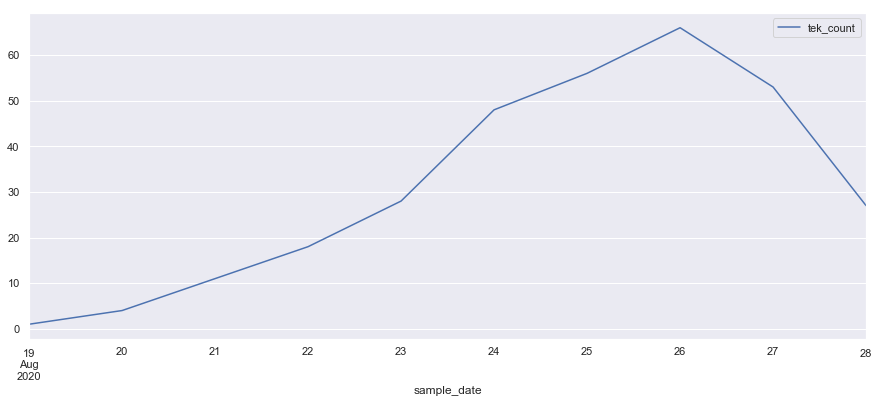

In [10]:
exposure_keys_summary_df[["tek_count"]].plot()

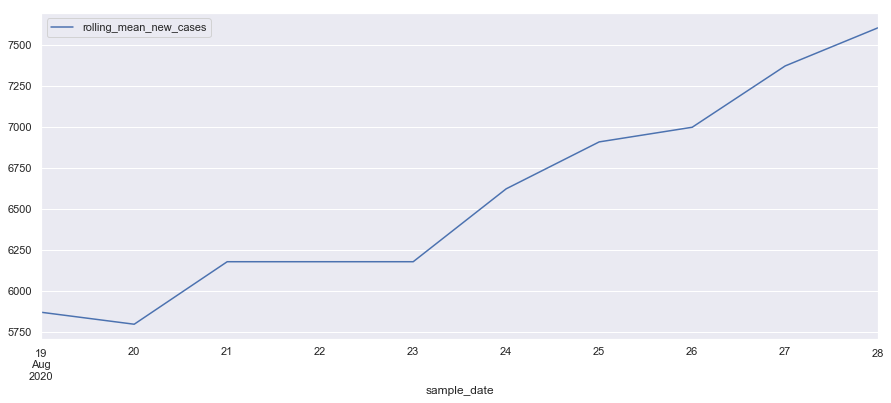

In [11]:
exposure_keys_summary_df[["rolling_mean_new_cases"]].plot()